In [1]:
import os
from glob import glob
import pandas as pd
import cv2
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm

In [2]:
base_path = "/kaggle/input/stroke/New_data_Stroke_ver3/CT"
classes = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

data = []
for label in classes:
    folder = os.path.join(base_path, label)
    images = glob(os.path.join(folder, "*.jpg")) + glob(os.path.join(folder, "*.png")) + glob(os.path.join(folder, "*.jpeg"))
    for img_path in images:
        data.append((img_path, label))

df = pd.DataFrame(data, columns=["path", "label"])

# Convert to binary classes
df['binary_label'] = df['label'].apply(lambda x: 'stroke' if x != 'normal' else 'normal')
print("\nAfter conversion:")
print(df['binary_label'].value_counts())

# Sample output
print("\nSample DataFrame:")
df.head()


After conversion:
binary_label
stroke    1111
normal     994
Name: count, dtype: int64

Sample DataFrame:


,path,label,binary_label
0,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,HEMORAGE STROK,stroke
1,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,HEMORAGE STROK,stroke
2,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,HEMORAGE STROK,stroke
3,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,HEMORAGE STROK,stroke
4,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,HEMORAGE STROK,stroke


In [3]:
df = df.drop(columns=['label'])
df.head()

,path,binary_label
0,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,stroke
1,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,stroke
2,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,stroke
3,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,stroke
4,/kaggle/input/stroke/New_data_Stroke_ver3/CT/H...,stroke



📂 Processing Class: stroke
🔍 Processing: 208.jpg


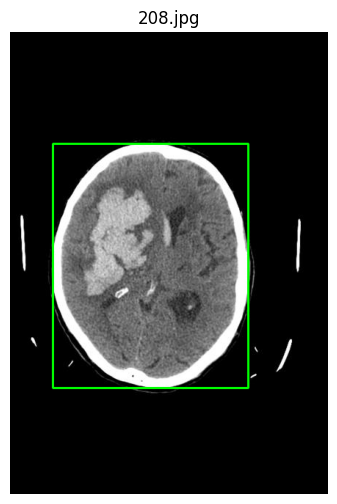

📦 Detected Box: (58, 152, 266, 333)
🔍 Processing: 473.jpg


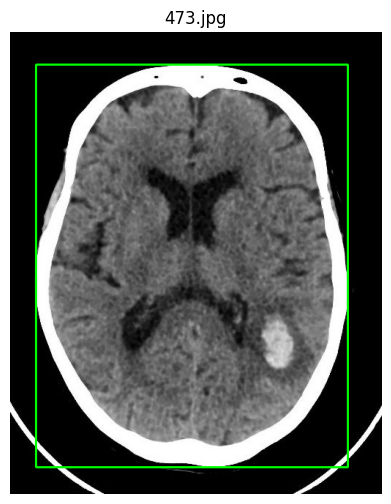

📦 Detected Box: (35, 44, 425, 549)

📂 Processing Class: normal
🔍 Processing: 623.jpg


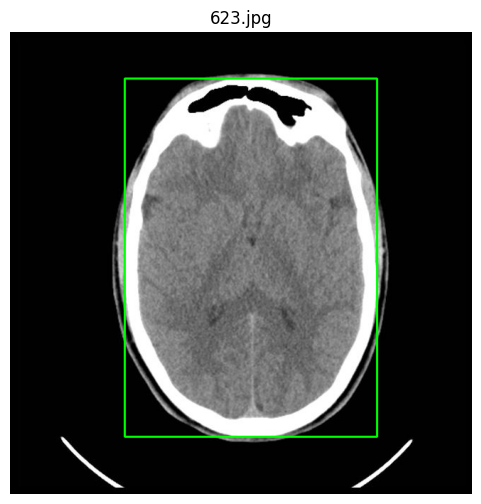

📦 Detected Box: (161, 65, 355, 504)
🔍 Processing: 764.jpg


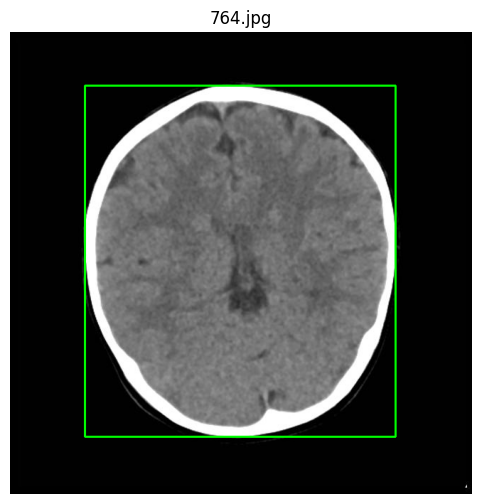

📦 Detected Box: (105, 75, 437, 494)


In [4]:
class TextRegionDetector:
    def __init__(self, min_width=10, min_height=10, threshold=220):
        self.min_width = min_width
        self.min_height = min_height
        self.threshold = threshold

    def load_image(self, path):
        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {path}")
        return image

    def detect_largest_region(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, self.threshold, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_box = None
        max_area = 0
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            if w >= self.min_width and h >= self.min_height and area > max_area:
                max_box = (x, y, w, h)
                max_area = area
        return max_box

    def draw_box(self, image, box, color=(0, 255, 0), thickness=2):
        if box:
            x, y, w, h = box
            cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
        return image

    def process(self, image_path, visualize=False):
        image = self.load_image(image_path)
        box = self.detect_largest_region(image)
        if visualize and box:
            image_with_box = self.draw_box(image.copy(), box)
            self._visualize(image_with_box, image_path)
        return box

    def _visualize(self, image, title=""):
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(title))
        plt.axis("off")
        plt.show()
    
    def crop_text_region(self, image):
        box = self.detect_largest_region(image)
        if box:
            x, y, w, h = box
            return image[y:y+h, x:x+w]
        return image


filtered_df = df[df['binary_label'].isin(['stroke', 'normal'])]

detector = TextRegionDetector()

for label in ['stroke', 'normal']:  # Process 'stroke' and 'normal' classes
    print(f"\n📂 Processing Class: {label}")
    
    # Filter the DataFrame to get paths for the current class
    class_df = filtered_df[filtered_df['binary_label'] == label]
    
    for img_path in class_df['path'].head(2):  # Process only the first 2 images
        print(f"🔍 Processing: {os.path.basename(img_path)}")
        box = detector.process(img_path, visualize=True)
        print(f"📦 Detected Box: {box}")


In [5]:
X = []
y = []

target_size = (224, 224)

for label in ['stroke', 'normal']:
    print(f"\n📂 Processing Class: {label}")
    
    # Filter images belonging to the current class
    class_df = filtered_df[filtered_df['binary_label'] == label]
    
    # Process the first few images for the current class (you can change the number)
    for img_path in class_df['path']:
        try:
            img = detector.load_image(img_path)  # Load the image
            cropped = detector.crop_text_region(img)  # Crop the text region
            resized = cv2.resize(cropped, target_size)  # Resize to 224x224
            X.append(resized)  # Append the processed image
            y.append(label)  # Append the label (stroke or normal)
        except Exception as e:
            print(f"Error in {img_path}: {e}")

# Convert lists into numpy arrays
X = np.array(X)
y = np.array(y)

print(f"✅ Loaded: {X.shape[0]} samples | Image shape: {X.shape[1:]}")



📂 Processing Class: stroke

📂 Processing Class: normal
✅ Loaded: 2105 samples | Image shape: (224, 224, 3)


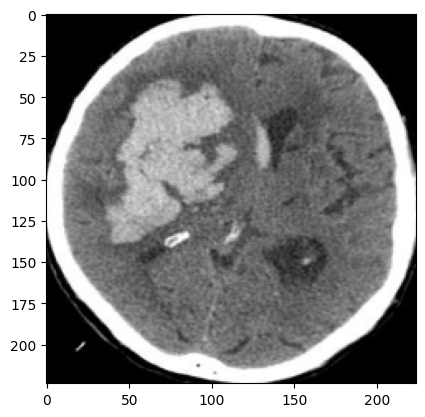

In [6]:
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))

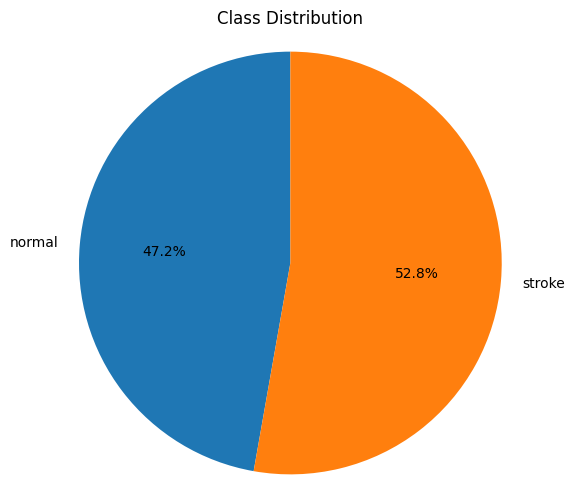

In [7]:
import matplotlib.pyplot as plt

unique_labels, class_counts = np.unique(y, return_counts=True)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()


In [8]:
y

array(['stroke', 'stroke', 'stroke', ..., 'normal', 'normal', 'normal'],
      dtype='<U6')

In [9]:
X = X.astype(np.float32) / 255.0


In [10]:
def normalize_image(img, to_range=(0, 1)):
    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    norm_img = (img - min_val) / (max_val - min_val + 1e-8)
    if to_range == (-1, 1):
        norm_img = norm_img * 2 - 1
    return norm_img

def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def preprocess_image(img, size=(224, 224), to_range=(0, 1)):
    return normalize_image(resize_image(img, size), to_range)

def apply_preprocessing(X, size=(224, 224), to_range=(0, 1)):
    return list(map(partial(preprocess_image, size=size, to_range=to_range), tqdm(X, desc="Preprocessing images")))

def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    val_ratio = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [11]:
X_processed = apply_preprocessing(X, size=(224, 224), to_range=(0, 1))

Preprocessing images: 100%|██████████| 2105/2105 [00:01<00:00, 1118.60it/s]


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
X = X.astype(np.float32) / 255.0  # Normalize
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [13]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X_processed, y_encoded)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1473, Val: 316, Test: 316


# Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# --- Plotting Training History ---
def plot_training_history(history, metrics=('loss', 'accuracy', 'auc')):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(5 * len(metrics), 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(epochs, history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history:
            plt.plot(epochs, history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [24]:
class CustomDataset(Dataset):
    def __init__(self, X, y, augment=False):
        # Ensure format: (N, C, H, W) from (N, H, W, C)
        self.X = np.moveaxis(X, -1, 1).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return torch.tensor(x), torch.tensor(y)



def to_torch_dataloader(X, y, batch_size=32, shuffle=True, augment=False):
    dataset = CustomDataset(X, y, augment=augment)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# --- Enhanced CNN Model ---
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No sigmoid — we'll use BCEWithLogitsLoss
        return x

# --- Optimizer, Loss and Scheduler ---
def get_loss():
    return nn.BCEWithLogitsLoss()

def get_optimizer(model, lr=1e-4):
    return torch.optim.Adam(model.parameters(), lr=lr)

def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [21]:
# --- Plotting Training History ---
def plot_training_history(history, metrics=('loss', 'accuracy', 'auc')):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(5 * len(metrics), 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(epochs, history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history:
            plt.plot(epochs, history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [25]:
train_ds = to_torch_dataloader(X_train, y_train)
val_ds = to_torch_dataloader(X_val, y_val, shuffle=False)
test_ds = to_torch_dataloader(X_test, y_test, shuffle=False)

model = EnhancedCNN()
optimizer = get_optimizer(model)
criterion = get_loss()

In [26]:
best_val_auc = 0
history = {'loss': [], 'accuracy': [], 'auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

scheduler = get_scheduler(optimizer)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true_train, y_pred_train = [], []

    for inputs, labels in train_ds:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    train_loss = running_loss / total
    train_acc = correct / total
    train_auc = f1_score(y_true_train, y_pred_train)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for inputs, labels in val_ds:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_auc = f1_score(y_true_val, y_pred_val)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_auc'].append(val_auc)

    scheduler.step(val_loss)  # 🔁 Optional LR scheduler

    print(f"Epoch {epoch+1}/20 | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/20 | Train Loss: 0.6069, Acc: 0.5906, AUC: 0.4668 | Val Loss: 0.7036, Acc: 0.5063, AUC: 0.1236
Epoch 2/20 | Train Loss: 0.4979, Acc: 0.7257, AUC: 0.7143 | Val Loss: 0.5057, Acc: 0.6582, AUC: 0.5814
Epoch 3/20 | Train Loss: 0.4405, Acc: 0.7821, AUC: 0.7850 | Val Loss: 0.4160, Acc: 0.7975, AUC: 0.8118
Epoch 4/20 | Train Loss: 0.4051, Acc: 0.7984, AUC: 0.7975 | Val Loss: 0.4239, Acc: 0.8259, AUC: 0.8525
Epoch 5/20 | Train Loss: 0.3651, Acc: 0.8405, AUC: 0.8405 | Val Loss: 0.3611, Acc: 0.8481, AUC: 0.8652
Epoch 6/20 | Train Loss: 0.3247, Acc: 0.8710, AUC: 0.8743 | Val Loss: 0.9275, Acc: 0.6424, AUC: 0.7472
Epoch 7/20 | Train Loss: 0.2963, Acc: 0.8778, AUC: 0.8774 | Val Loss: 0.3543, Acc: 0.8892, AUC: 0.9008
Epoch 8/20 | Train Loss: 0.2980, Acc: 0.8778, AUC: 0.8795 | Val Loss: 0.2763, Acc: 0.8544, AUC: 0.8467
Epoch 9/20 | Train Loss: 0.2487, Acc: 0.9009, AUC: 0.9031 | Val Loss: 0.2039, Acc: 0.9051, AUC: 0.9068
Epoch 10/20 | Train Loss: 0.2394, Acc: 0.9029, AUC: 0.9056 | Val Loss: 0.

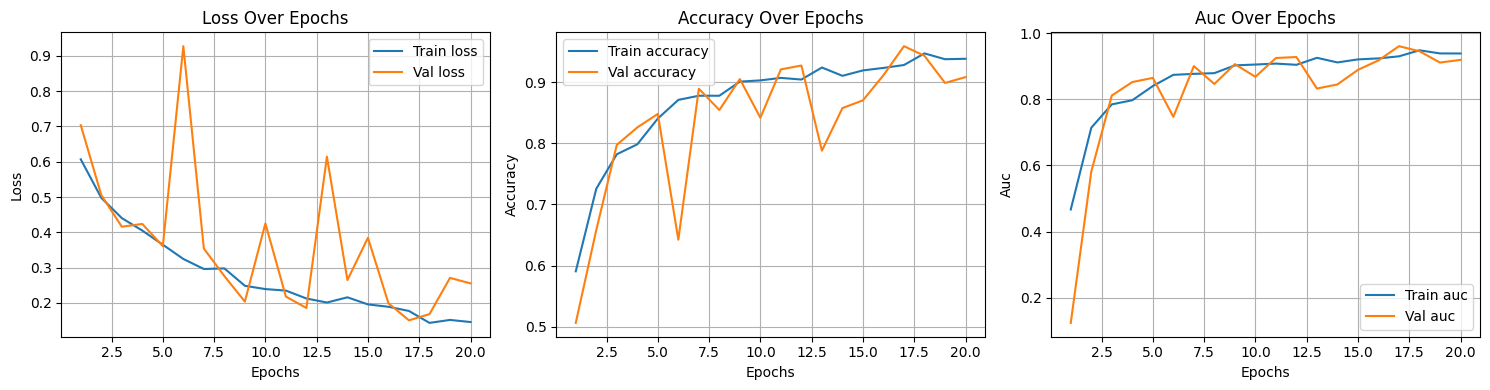

In [29]:
plot_training_history(history, metrics=('loss', 'accuracy', 'auc'))

In [30]:
# --- Evaluate on Test Set ---
print("\n✅ Loading best model for evaluation...")
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

y_true_test, y_pred_test = [], []

with torch.no_grad():
    for inputs, labels in test_ds:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())


✅ Loading best model for evaluation...


/tmp/ipykernel_31/2592587979.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


In [31]:
# --- Metrics ---
from sklearn.metrics import classification_report, confusion_matrix

print("\n🧾 Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=["Normal", "Stroke"]))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_true_test, y_pred_test))


🧾 Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       149
      Stroke       0.94      0.95      0.94       167

    accuracy                           0.94       316
   macro avg       0.94      0.94      0.94       316
weighted avg       0.94      0.94      0.94       316


🧮 Confusion Matrix:
[[138  11]
 [  8 159]]


In [32]:
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for inputs, labels in test_ds:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

test_loss /= test_total
test_accuracy = test_correct / test_total
test_auc = f1_score(y_true_test, y_pred_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

Test Loss: 0.16877077765102627
Test Accuracy: 0.9430379746835443
Test AUC: 0.9457831325301206


In [33]:
def visualize_predictions(model, dataloader, num_samples=20):
    model.eval()
    data_iter = iter(dataloader)
    plt.figure(figsize=(20, 4))
    shown = 0

    with torch.no_grad():
        while shown < num_samples:
            inputs, labels = next(data_iter)
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            inputs = inputs.cpu().numpy()
            labels = labels.numpy()

            for i in range(len(inputs)):
                if shown >= num_samples:
                    break
                plt.subplot(2, 10, shown + 1)
                img = inputs[i][0]  # grayscale
                true_label = labels[i]
                pred_label = preds[i]
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                title = f"True: {'Stroke' if true_label == 1 else 'Normal'}\nPred: {'Stroke' if pred_label > 0.5 else 'Normal'}"
                plt.title(title, fontsize=10)
                shown += 1
    plt.tight_layout()
    plt.show()

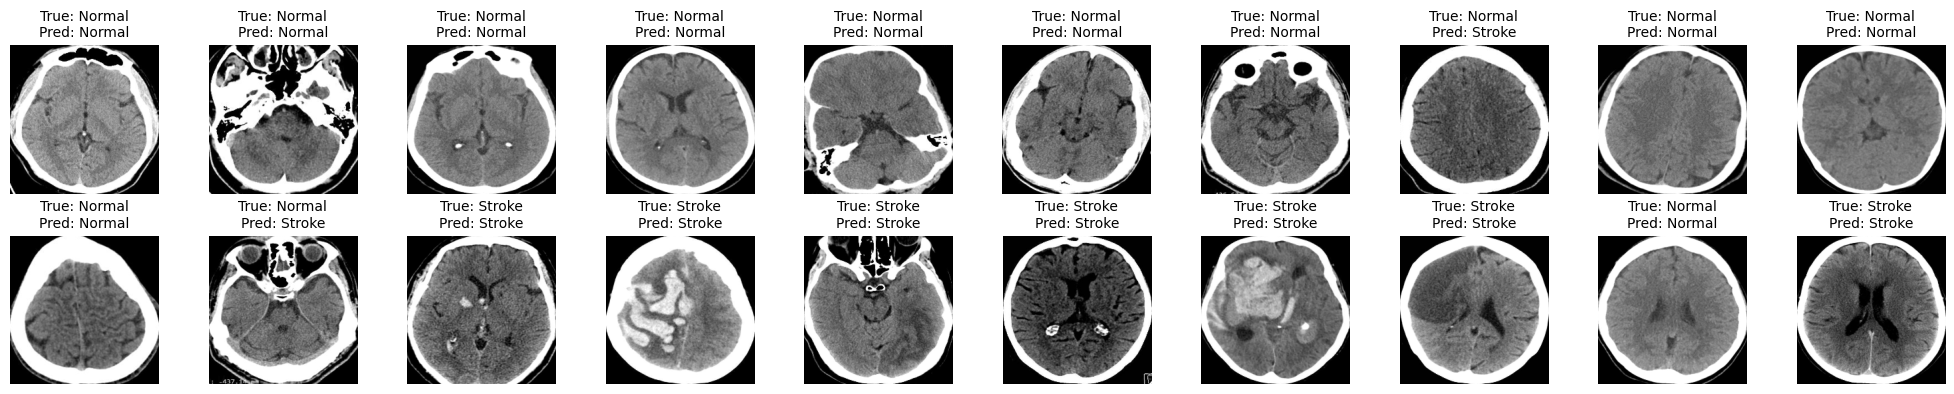

In [34]:
visualize_predictions(model, test_ds, num_samples=20)